In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


#prepare object points and image points for caliberation

objp = np.zeros((6*9,3),np.float32)
#fill up with points from (0,0,0) .....(8,5,0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


#Arrays to store object & image points from images
obj_points=[]
img_points=[]

#read caliberation examples with globe
images = glob.glob('camera_cal/calibration*.jpg')



print("finding corners on given images......")
#steps to search corners we iterate through images
for idx, fname in enumerate(images):

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #find the corners
    ret , corners = cv2.findChessboardCorners(gray,(9,6) ,None)

    #if ret true then draw corners on chessboard and save it to a file
    if ret ==True:
        print('workin on ',fname)
        #append points to array placeholders 
        obj_points.append(objp)
        img_points.append(corners)
        
        #Draw chessboard corners on original image and save it to a file
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        cv2.imwrite('./camera_cal/caliberation_corners'+str(idx)+'.jpg',img)

img = cv2.imread('./camera_cal/caliberation_corners10.jpg')
print("finding corners completed and pickle file is saved")



finding corners on given images......
workin on  camera_cal/calibration10.jpg
workin on  camera_cal/calibration11.jpg
workin on  camera_cal/calibration12.jpg
workin on  camera_cal/calibration13.jpg
workin on  camera_cal/calibration14.jpg
workin on  camera_cal/calibration15.jpg
workin on  camera_cal/calibration16.jpg
workin on  camera_cal/calibration17.jpg
workin on  camera_cal/calibration18.jpg
workin on  camera_cal/calibration19.jpg
workin on  camera_cal/calibration2.jpg
workin on  camera_cal/calibration20.jpg
workin on  camera_cal/calibration3.jpg
workin on  camera_cal/calibration6.jpg
workin on  camera_cal/calibration7.jpg
workin on  camera_cal/calibration8.jpg
workin on  camera_cal/calibration9.jpg
finding corners completed and pickle file is saved


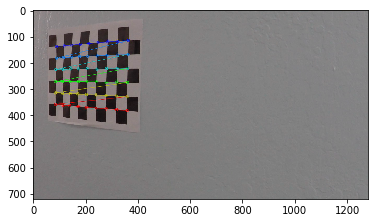

In [2]:
#make sure we found corners
img = cv2.imread('./camera_cal/caliberation_corners10.jpg')

plt.imshow(img)


In [9]:
import pickle
# w,h = img.shape
#Caliberate and create a pickle file to save calibrated mtx and distance values
imgsize = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, imgsize,None,None)

# Save 
dist_pickle = {} #empty dictionary
dist_pickle["mtx"] = mtx 
dist_pickle["dist"] = dist
filename = './camera_cal/calib_dist_mtx.p'
pickle.dump( dist_pickle, open( filename, "wb" ) )

print("mtx and dist are dumped into pickle file as {} ".format(filename))

mtx and dist are dumped into pickle file as ./camera_cal/calib_dist_mtx.p 


In [76]:
#helper function to undistort and transofrm
def plot_points(img):
    
    plt.imshow(img)
    plt.plot(800,500,'o') #topright
    plt.plot(1120,700,'o') #bottomright
    plt.plot(540,500,'o') #topleft
    plt.plot(270,700,'o') #bottomleft


def subplot_images(img1,img2,title1,title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1,cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2,cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def cal_undistort(img, mtx, dist):
    # grayscale first
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#warp image to get a bird eye view
def warp(img,dst,src):
    #grayscale image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1],gray.shape[0])
    src = np.float32([[270,700],[540,500],[1120,700],[800,500]])
    dst = np.float32([[270,700],[270,500],[1120,700],[1120,500]])
    M = cv2.getPerspectiveTransform(src,dst)
    minV = cv2.getPerspectiveTransform(dst,src) 
    warped = cv2.warpPerspective(img,M,img_size, flags = cv2.INTER_LINEAR)
    return warped,M ,minV

def unwarp(warp_img,minV):
    img_size = (warp_img.shape[1],warp_img.shape[0])
    unwarped = cv2.warpPerspective(warp_img,minV,img_size, flags = cv2.INTER_LINEAR)
    return unwarped
#unwarp image to original perspective
        

In [77]:
#load pickle for mtx and dist to be used later for undistort
calib_dist = pickle.load(open(filename,"rb"))
mtx = calib_dist["mtx"]
dist = calib_dist["dist"]

In [43]:
#load test images and iterate over each to undistort and warp

test_imgs = glob.glob('test_images/*.jpg')


for idx, fname in enumerate(test_imgs):
    #pipeline begins here: goal is to undistort and 
    #warp lane line images bird eye view
    img = cv2.imread(fname)
    print('workin on ',fname)  
    undist = cal_undistort(img, mtx, dist)

    
#     cv2.imwrite('./warped_imgs/warped'+str(idx)+'.jpg',res)


workin on  test_images/straight_lines1.jpg
workin on  test_images/straight_lines2.jpg
workin on  test_images/test1.jpg
workin on  test_images/test2.jpg
workin on  test_images/test3.jpg
workin on  test_images/test4.jpg
workin on  test_images/test5.jpg
workin on  test_images/test6.jpg


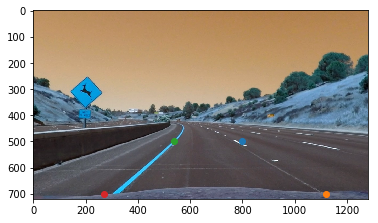

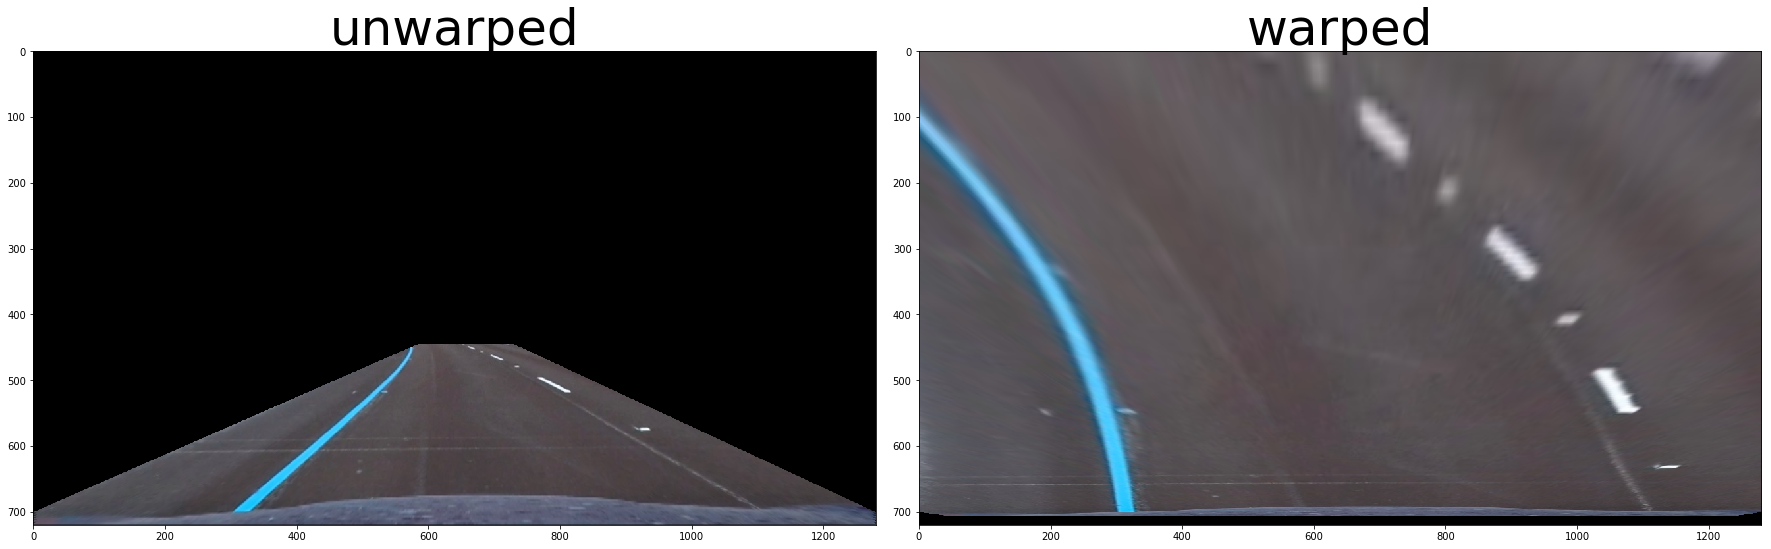

In [79]:
#test undist and warp before feeding all images
tst_img = cv2.imread('./test_images/test2.jpg')

#undistort
undist = cal_undistort(tst_img,mtx,dist)

#manually calculated points for source and warped destination image

src = np.float32([[270,700],[540,500],[1120,700],[800,500]])
dst = np.float32([[270,700],[270,500],[1120,700],[1120,500]])

#draw manually calculated points on image
plot_points(undist)

#warp image bird-eye-view/top down
warp_img ,M , minV = warp(undist ,src,dst)

unwarp_img = unwarp(warp_img,minV)

subplot_images(unwarp_img,warp_img,"unwarped","warped")

#